# 灰色关联分析
对于两个系统之间的因素，其随时间或不同对象而变化的关联性大小的量度，称为关联度。在系统发展过程中，若两个因素变化的趋势具有一致性，即同步变化程度较高，即可谓二者关联程度较高；反之，则较低。因此，灰色关联分析方法，是根据因素之间发展趋势的相似或相异程度，亦即“灰色关联度”，作为衡量因素间关联程度的一种方法

### 不反映相关性

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #绘制热图
import math
%matplotlib inline

In [2]:
'''
指标正向化: 和topsis的一致
@args:
    data - numpys的array类型，所有要处理的数据
    mini - list[]，极小化指标所在列 
    mid - list[]，中间型指标所在列 
    mid_best - list[],中间型指标最优值
    interval - list[]，区间型指标所在列
    interval_best - two lists[[lower,upper],...]，区间型指标最优上下界
@return:
    data - numpys的array类型，正向化后的所有数据
'''
def IndexPositive(data = None,mini = [], mid = [], mid_best = [], interval = [], interval_best = [[]]):
    #如果指标是极小型
    for i in mini:
        max_num = max(data[:,i])
        data[:,i] = max_num - data[:,i] #通过max-x转为极大值
        
    #中间型
    k = 0
    for i in mid:
        m_b = mid_best[k]
        max_num = max(abs(data[:,i]-m_b))
        data[:,i] = [1-(abs(elem-m_b)/max_num) for elem in data[:,i]]
        k += 1
        
    #区间型
    k = 0
    for i in interval:
        a = interval_best[k][0]
        b = interval_best[k][1]
        
        max_num = max(a-min(data[:,i]),max(data[:,i]-b))
        
        for j in range(len(data[:,1])):
            if data[j][i] < a:
                data[j][i] = 1-(a-data[j][i])/max_num
            elif data[j][i] >= a and data[j][i] <= b:
                data[j][i] = 1
            else:
                data[j][i] = 1-(data[j][i]-b)/max_num
        k += 1
        
    return data  

In [14]:
'''
计算灰色关联系数和关联度
过程: 数据预处理，设置母序列，计算灰色关联系数，获得指标平均数计算关联度
@args:
    data: np.array类型。正向化后的数据
    ranges:list[]。要处理的数据列数
    mum_list:list[]。如果数据中有母序列则不需自己建，但要进行标准化处理
@return:
    data: np.array类型。经过预处理的数据
    GRA_ratio: list[], 灰色关联系数
    GRA_degrees: list[], 灰色关联度
    mum_list:list[],可以用来验证
    data_cal：np.array类型。|x0-xi|
'''
def CalGRA(data = None,rou = 0.5,mum_list = []):
    #数据预处理每列除以每列均值
    #若矩阵中有负数，则
    if np.any(data<0): #会将每个元素和0比较
        data = (data-np.mean(data,axis = 0))/np.std(data,axis = 0)
    else:
        data = data/np.mean(data,axis=0)
    
    #获取母序列
    if mum_list == []:
        mum_list = np.max(data,axis=1)
        mum_list = mum_list.reshape(-1,1) #一维转二维；a.reshape(-1)是转一维
    else:
        mum_list = np.array(mum_list).reshape(-1,1)
        mum_list = mum_list/np.mean(mum_list)
    
    #计算灰色关联系数
    data_cal = abs(data-mum_list) #每列都减去母序列
    a = data_cal.item(np.argmin(data_cal))
    b = data_cal.item(np.argmax(data_cal))
    GRA_ratio = (a+rou*b)/(data_cal+rou*b)
    #该项平均值计算关联度
    GRA_degrees = np.mean(GRA_ratio,axis=0)
    
    return data, GRA_ratio, GRA_degrees, mum_list, data_cal

'''
计算样本的得分
过程: 通过关联度计算权重，计算得分并归一化
@args:
    data_normalized: np.array，经过正向化和标准化的数据
    GRA_degrees: 指标的灰色关联度
@return:
    scores_nn: list[]，样本未归一化的得分
    scores_n: list[]，样本归一化后得分
'''
def CalWeights(data_normalized = None, GRA_degrees = None):
    #关联度计算权重
    d_sum = sum(GRA_degrees)
    weights = GRA_degrees/d_sum
    #计算得分并归一化
    scores_nn = np.dot(data_normalized,GRA_degrees.transpose()) #data_normalized, m*n;GRA_degrees.transpose(转置):n*1.每行求乘积的和
    s_sum = sum(scores_nn)
    scores_n = scores_nn/s_sum
    
    return scores_nn,scores_n

In [26]:
'''
灰色关联度折线图，横坐标为指标，纵为灰色关联度
@args:
    quota_labels: list[], 指标标签，放x轴。和待处理data的列对应
    GRA_degrees: 灰色关联度，放y
    f_num: 小数保留的位数，默认4
'''
def ShowGRA_extent(quota_labels = None, GRA_degrees = None,f_num = 4):
    #绘图时显示中文
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.figsize'] = (35.0, 20.0)
    plt.subplot(111)
        
    min_degree = round(min(GRA_degrees),f_num)
    max_degree = round(max(GRA_degrees),f_num)+math.pow(10,-(f_num-1))
    step = (max_degree-min_degree)/10
    y_loc = np.arange(min_degree,max_degree,step)
    y_labels = list(y_loc) #list(range(x1,x2,step))中只能为整数步长，小数的话将range换成np.arange
    n = len(y_labels)
    y_labels = [round(num,f_num) for num in y_labels]
    y_labels = map(str,y_labels)
        
    plt.xticks(ticks = np.arange(len(quota_labels)),labels = quota_labels,fontsize = 40)
    plt.yticks(ticks = y_loc,labels = y_labels, 
               fontsize = 50) 
    plt.plot(GRA_degrees, color = '#2b73af', linewidth = 3)
    for a,b in zip(range(len(quota_labels)),GRA_degrees): #显示数据值
        plt.text(a,b,round(b,f_num+2),va = 'bottom', ha="center",fontweight="bold",fontsize = 40)
    
    
    plt.xlabel('指标',fontsize = 60,verticalalignment = 'bottom',labelpad = 80)
    plt.ylabel('灰色关联度',fontsize = 60,verticalalignment = 'bottom',labelpad = 80)
    
    plt.savefig('./gra/line.png')
    plt.show()
    
'''
样本得分前10排序柱状图，由大到小
@args:
    sample_labels: 样本标签，放x轴。最好是字符串型，否则报错（GDP例子）
    scores_n: 归一化后得分，y轴
'''
def ShowScoresTen(sample_labels = None,scores_n = None):
    #将sample_labels和scores_n都改为连接的字典，方便排序后对应
    scores_n = {sample_labels[i]:scores_n[i] for i in range(len(scores_n))}
    
    #绘图时显示中文
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.figsize'] = (30.0, 20.0)
    plt.subplot(111)
    
    #排序
    #由大到小(reverse),key = lambda x:x[1]按值排、x[0]按键
    scores_n = sorted(scores_n.items(),key = lambda x:x[1],reverse = True)
    print(scores_n)
    
    #前10的样本，没到10个就取所有样本数
    num = len(scores_n)
    if num > 10:
        num = 10
    
    x = []
    y = []
    #没找到其他方法，先暴力试试
    k = 0
    for item in scores_n:
        if k == num:
            break
            
        x.append(item[0])
        y.append(item[1])
        
        k += 1
    
    plt.bar(x, y, alpha = 0.5, align = 'center')
    for a,b in zip(x,y): #显示数据值
        plt.text(a,b,round(b,4),va = 'bottom', ha="center",fontweight="bold",fontsize = 30) 
    
    plt.xticks(ticks = np.arange(len(x)),labels = x,fontsize = 50)
    plt.yticks(fontsize = 50)
    plt.xlabel('样本',fontsize = 60,verticalalignment = 'baseline',labelpad = 80)
    plt.ylabel('样本得分',fontsize = 60,verticalalignment = 'bottom',labelpad = 80)
    
    plt.savefig('./gra/ScoresRank10.png')
    plt.show()

In [27]:
'''
使用上述函数
'''
# 导入数据
import time
start =  time.perf_counter() 
data = pd.read_excel(r'D:\desktop\2022数模国赛\练习\20条河流水质.xlsx') #r避免所有转义字符；sheet_name：名字或序号
end =  time.perf_counter()

print(f'导入时间：%f s'%(end-start))
data.head()

导入时间：0.019457 s


,河流,含氧量（ppm),PH值,细菌总数(个/mL),植物性营养物量（ppm)
0,A,4.69,6.59,51,11.94
1,B,2.03,7.86,19,6.46
2,C,9.11,6.31,46,8.91
3,D,8.61,7.05,46,26.43
4,E,7.13,6.50,50,23.57


In [28]:
# 数据处理，去除字符型（样本标签另放）
# 删除行列 drop
sample_labels = data.pop('河流') 
sample_labels = list(sample_labels)

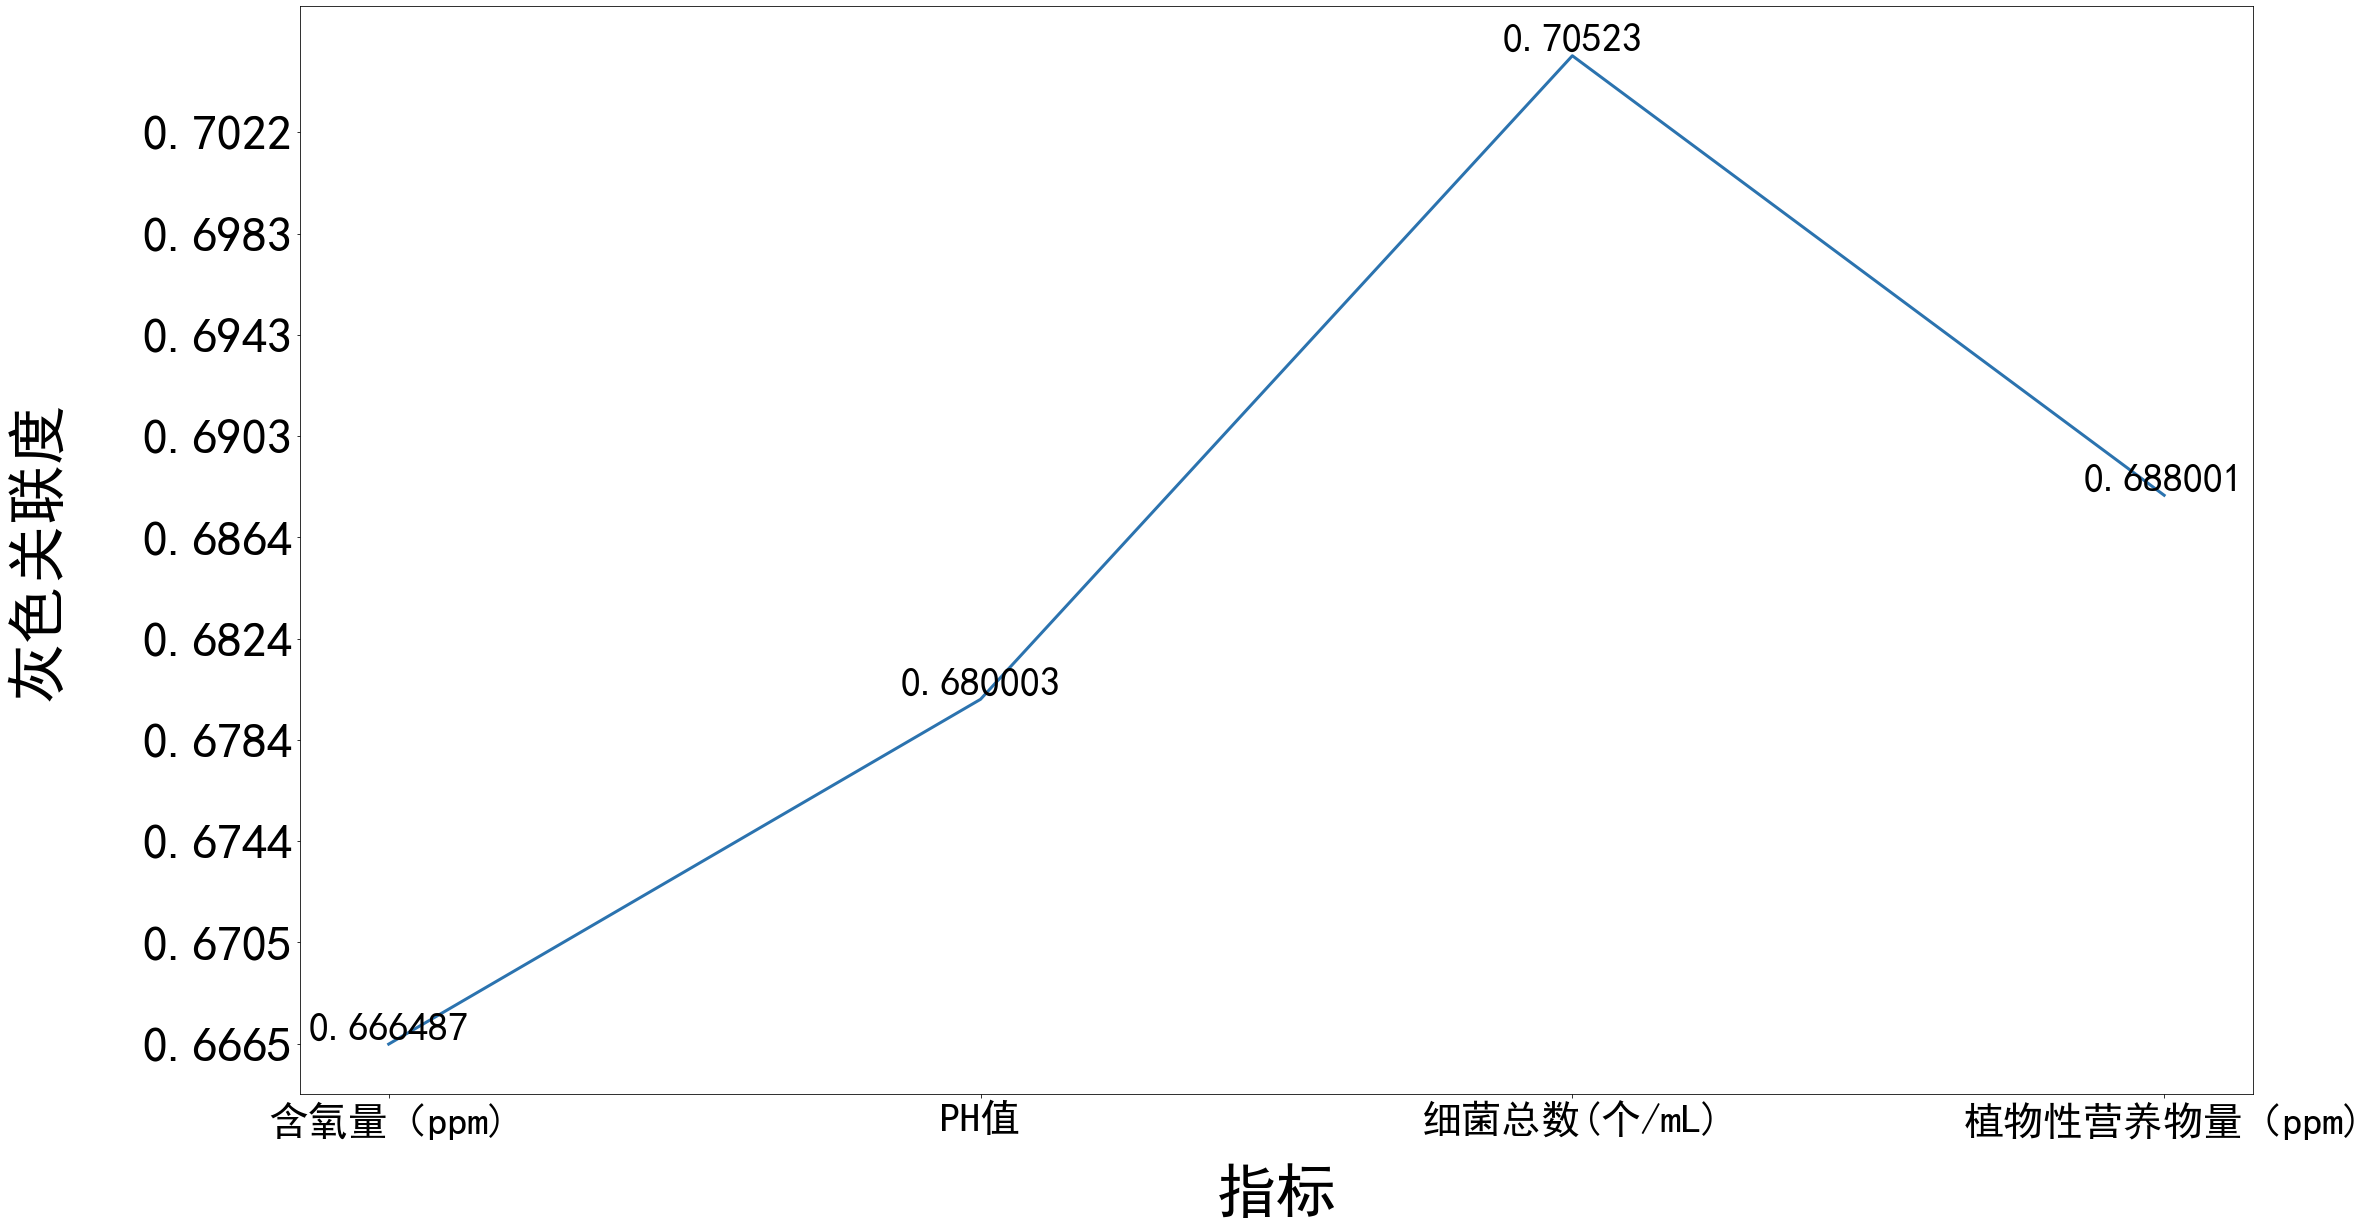

[('I', 0.07029007629803997), ('K', 0.06866783910781206), ('J', 0.06592176189655734), ('L', 0.05756719943896571), ('T', 0.0571621065773956), ('G', 0.05528228891694165), ('M', 0.05493684970579254), ('O', 0.05326761551235487), ('H', 0.052856294028422394), ('C', 0.05126482375977776), ('D', 0.05089714028942244), ('B', 0.04600082486571338), ('Q', 0.04576257338131808), ('A', 0.04526180899515915), ('R', 0.044907570896252594), ('P', 0.044292595792203154), ('E', 0.043671145048967325), ('F', 0.04320106195010086), ('S', 0.032105570138653866), ('N', 0.016682853400149324)]


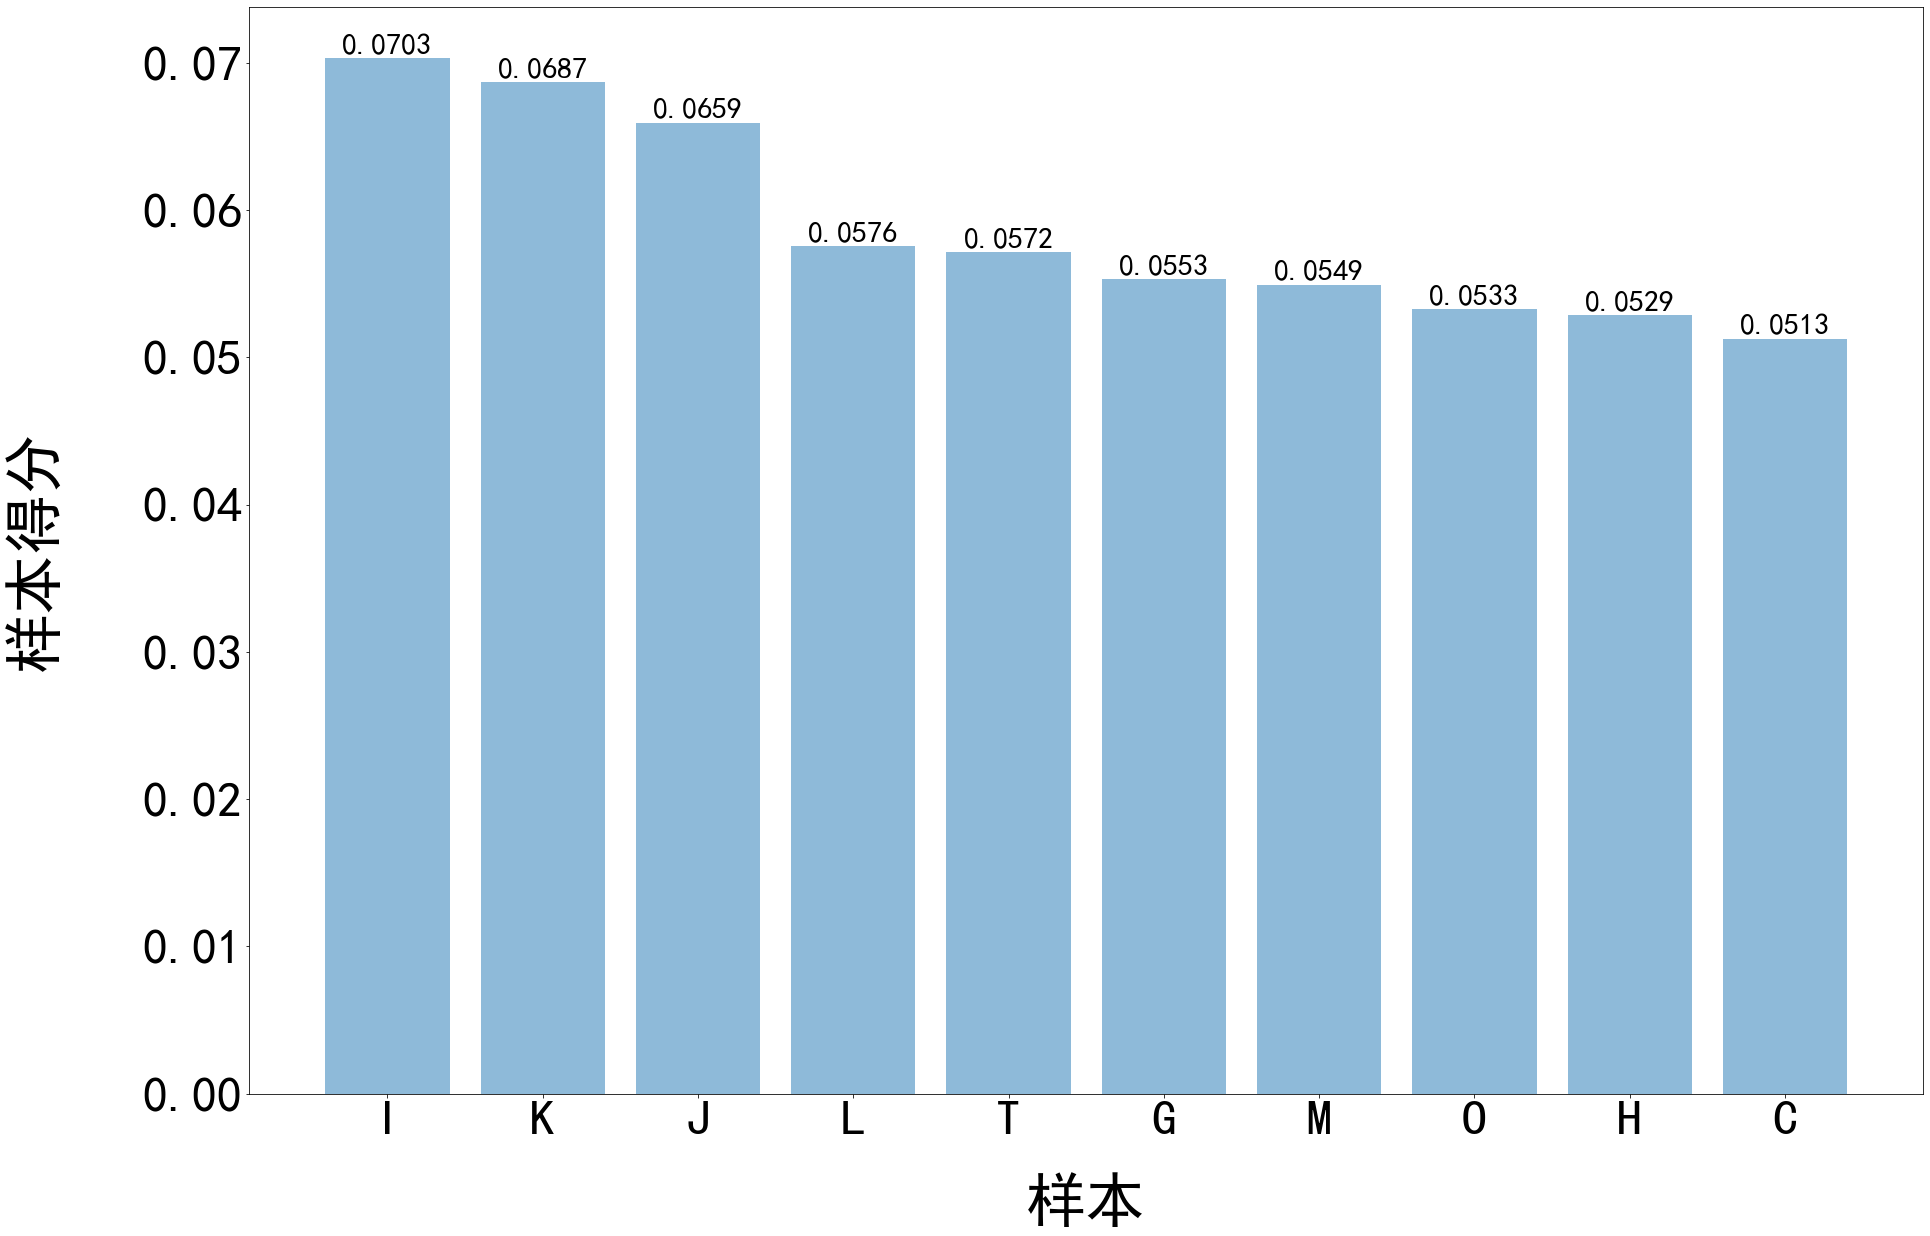

In [29]:
''' GRA(灰色关联分析)过程'''
data_a = np.array(data)

# 指标正向化的调用
data_a = IndexPositive(data = data_a, mini = [2], mid = [1], mid_best = [7], interval=[3], interval_best=[[10,20]])###!!!若变动需改
# 计算关联度
data_normal, GRA_ratio, GRA_degrees,mum_list, data_cal= CalGRA(data = data_a,rou = 0.5)
# 绘制关联度折线图 -> 实在不行复制到excel画图吧
q_labels = ['含氧量（ppm)','PH值','细菌总数(个/mL)','植物性营养物量（ppm)'] ###!!!若变动需改
ShowGRA_extent(quota_labels = q_labels, GRA_degrees = GRA_degrees)

# 计算得分
scores_nn,scores_n = CalWeights(data_normalized = data_normal, GRA_degrees = GRA_degrees)
# 绘制前10得分
ShowScoresTen(sample_labels = sample_labels,scores_n = scores_n) ###sample_labels若变动需改

In [8]:
# test
import time
start =  time.perf_counter() 
data = pd.read_excel(r'D:\desktop\2022数模国赛\练习\GDP.xlsx',sheet_name=1) #r避免所有转义字符；sheet_name：名字或序号
end =  time.perf_counter()

print(f'导入时间：%f s'%(end-start))
data.head()

导入时间：0.041340 s


,年份,国内生产总值,第一产业,第二产业,第三产业
0,2000,1988,386,839,763
1,2001,2061,408,846,808
2,2002,2335,422,960,953
3,2003,2750,482,1258,1010
4,2004,3356,511,1577,1268


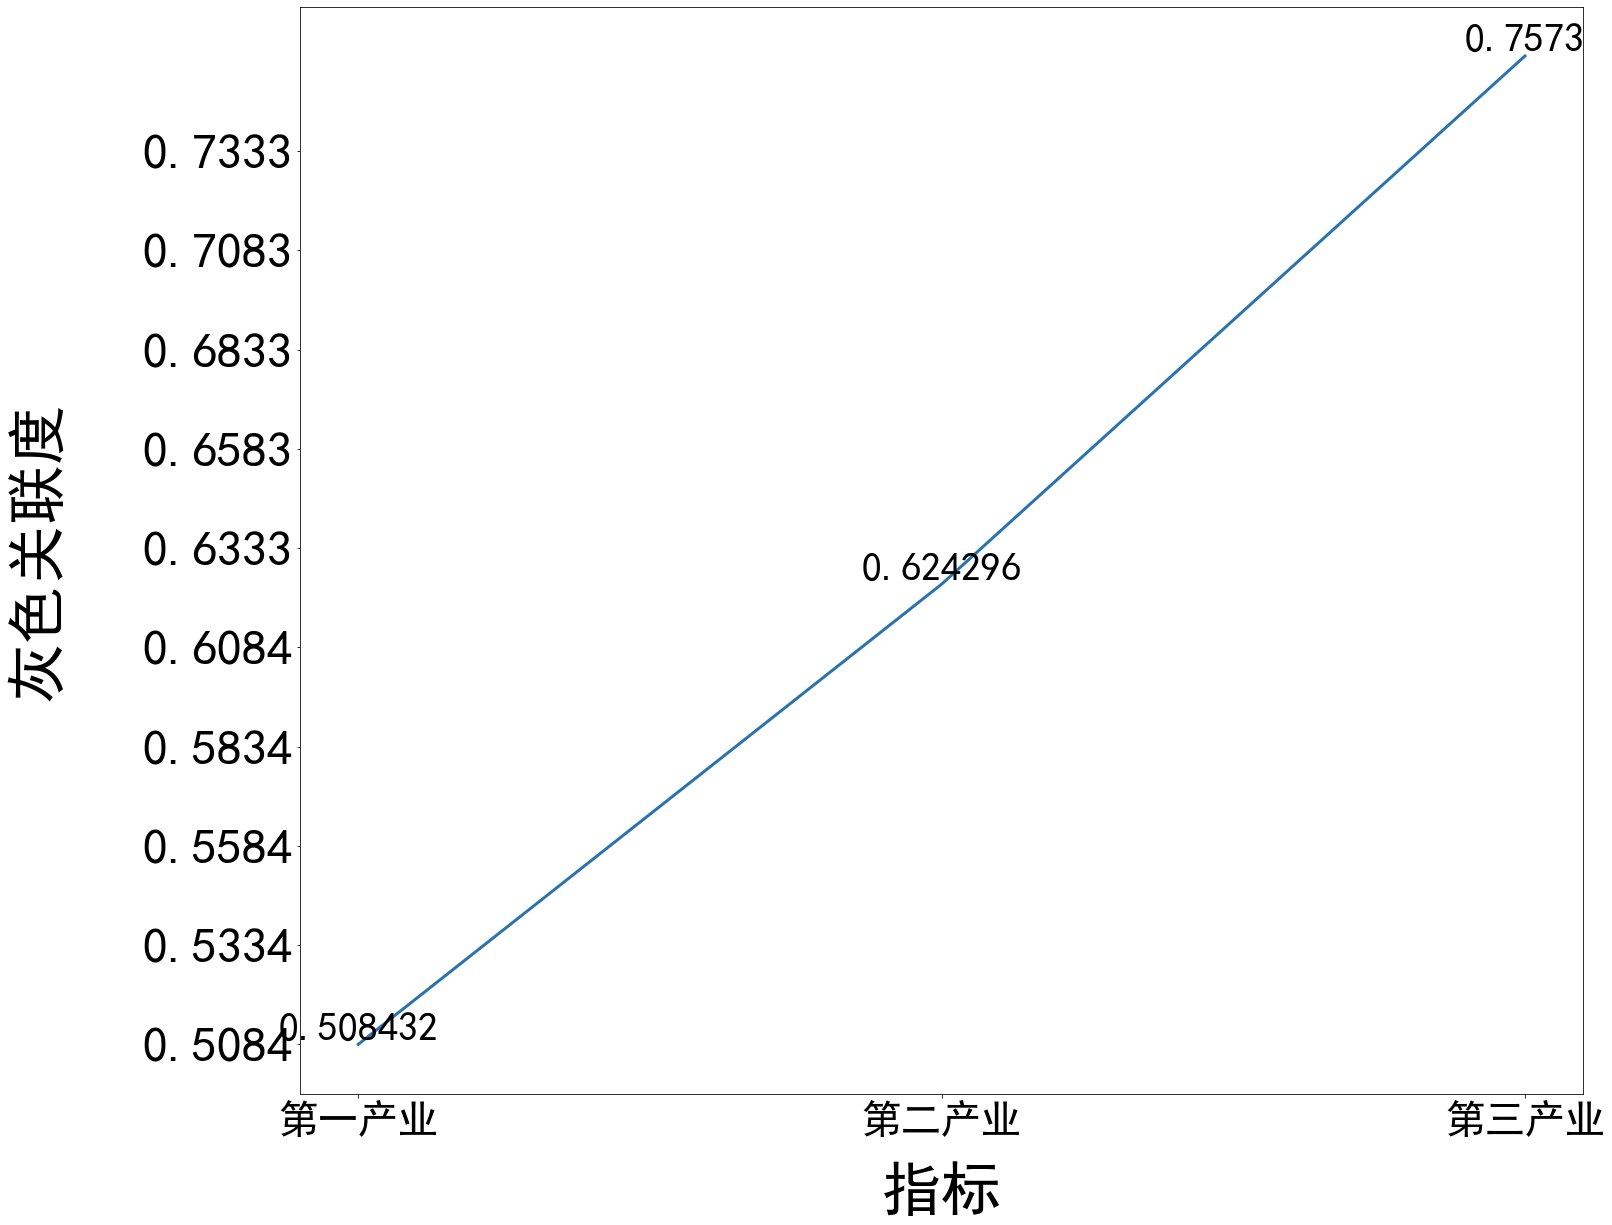

[('2005', 0.2273153517422019), ('2004', 0.20283364547854055), ('2003', 0.1689279567199589), ('2002', 0.14603944990989332), ('2001', 0.13013181638070276), ('2000', 0.1247517797687025)]
x: <class 'list'> 
 ['2005', '2004', '2003', '2002', '2001', '2000']
y: <class 'list'> 
 [0.2273153517422019, 0.20283364547854055, 0.1689279567199589, 0.14603944990989332, 0.13013181638070276, 0.1247517797687025]


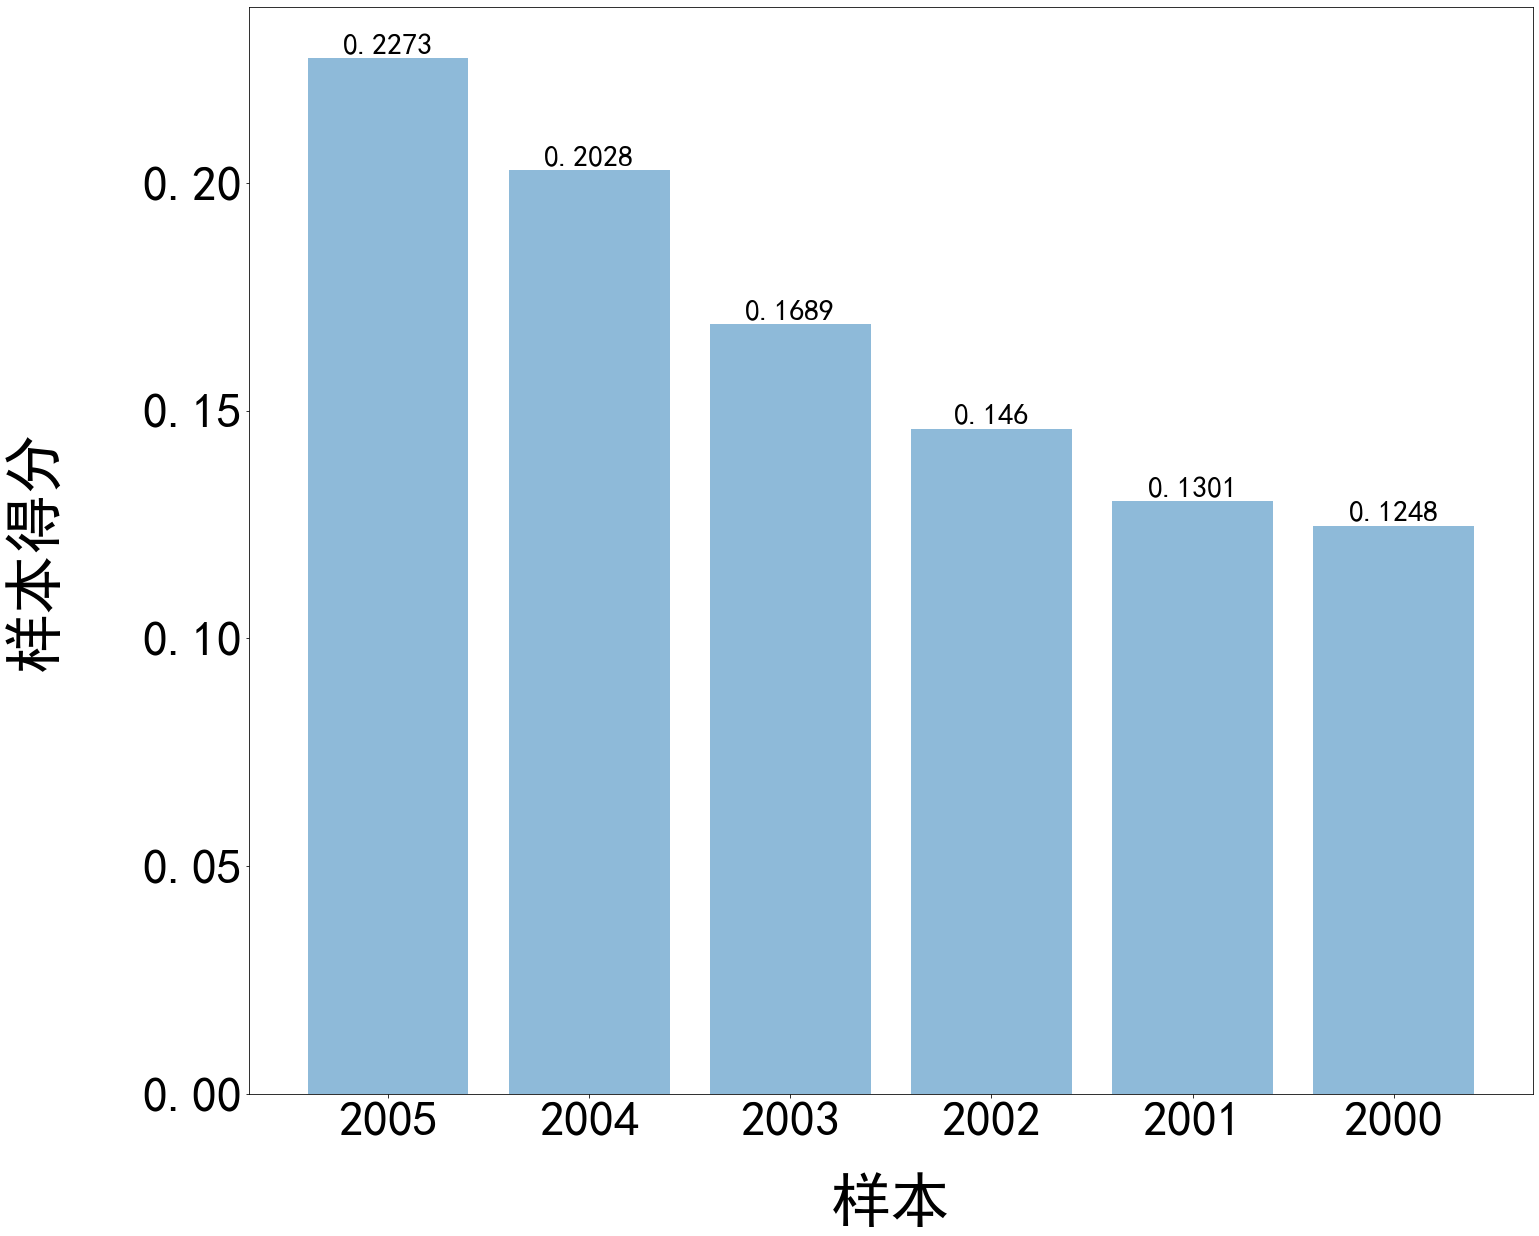

In [9]:
sample_labels = list(data.pop('年份')) #pop修改data，导致每次重新运行都要重新导入excel...
sample_labels = [str(year) for year in sample_labels]

mum_list = list(data.pop('国内生产总值'))
data_a = np.array(data)

# 指标正向化的调用
data_a = IndexPositive(data = data_a, mini = [], mid = [], mid_best = [], interval=[], interval_best=[[]])###!!!若变动需改
# 计算关联度
data_normal, GRA_ratio, GRA_degrees,mum_list,data_new = CalGRA(data = data_a,rou = 0.5,mum_list = mum_list)
# 绘制关联度折线图 -> 实在不行复制到excel画图吧
q_labels = ['第一产业','第二产业','第三产业'] ###!!!若变动需改
ShowGRA_extent(quota_labels = q_labels, GRA_degrees = GRA_degrees)
# 计算得分
scores_nn,scores_n = CalWeights(data_normalized = data_normal, GRA_degrees = GRA_degrees)
# 绘制前10得分
ShowScoresTen(sample_labels = sample_labels,scores_n = scores_n) ###sample_labels若变动需改

In [ ]:
(0.00062845+0.5*0.18616302)/(data_new+0.5*0.18616302)

In [ ]:
(np.argmin(data_new)+0.5*np.argmax(data_new))/(data_new+0.5*np.argmax(data_new))